<a href="https://colab.research.google.com/github/snoop2head/covid19_unknown_spread/blob/master/forecast_seoul_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/snoop2head/covid19_unknown_spread

Cloning into 'covid19_unknown_spread'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (420/420), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 420 (delta 175), reused 356 (delta 111), pack-reused 0
Receiving objects: 100% (420/420), 20.15 MiB | 14.12 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [2]:
!ls

covid19_unknown_spread	sample_data


In [3]:
%cd covid19_unknown_spread/

/content/covid19_unknown_spread


In [10]:
df = pd.read_csv("dataset_predict/df_train.csv", encoding="utf-8")
df.head()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
0,2020-01-24,1,0,NaN,1,1,0
1,2020-01-25,0,0,0.0,1,1,0
2,2020-01-26,0,0,0.0,1,1,0
3,2020-01-27,0,0,0.0,0,0,0
4,2020-01-28,0,0,0.0,0,0,0


In [11]:
df.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
232,2020-09-12,34,13,12.0,0,1,3
233,2020-09-13,41,8,15.0,0,1,3
234,2020-09-14,36,10,10.0,0,0,0
235,2020-09-15,49,14,14.0,0,0,0
236,2020-09-16,58,24,18.0,0,0,0


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

print(tf.keras.__version__)
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2.4.0
2.3.0
1.0.5
1.18.5


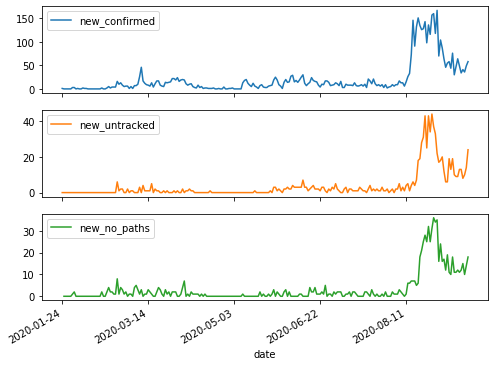

In [16]:
plot_cols = ['new_confirmed', 'new_untracked', 'new_no_paths']
plot_features = df[plot_cols]
plot_features.index = df["date"]
_ = plot_features.plot(subplots=True)

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_confirmed,237.0,20.493671,33.886853,0.0,3.0,9.0,18.0,167.0
new_untracked,237.0,3.582278,7.733278,0.0,0.0,1.0,3.0,44.0
new_no_paths,236.0,3.411017,6.867479,0.0,0.0,1.0,2.0,36.0
is_holiday,237.0,0.033755,0.180981,0.0,0.0,0.0,0.0,1.0
is_weekend,237.0,0.430380,0.496177,0.0,0.0,0.0,1.0,1.0
gov_policy,237.0,0.354430,0.957194,0.0,0.0,0.0,0.0,3.0


In [31]:
shift_days = 1
shift_steps = shift_days * 5
target_names = ['date','new_confirmed', 'new_untracked', 'new_no_paths']
df_targets = df[target_names]
df_targets.index = pd.DatetimeIndex(df_targets["date"])
df_targets = df_targets[['new_confirmed', 'new_untracked', 'new_no_paths']].shift(-shift_steps)

In [32]:
df_targets.tail(10)

,new_confirmed,new_untracked,new_no_paths
date,,,
2020-09-07,34.0,13.0,12.0
2020-09-08,41.0,8.0,15.0
2020-09-09,36.0,10.0,10.0
2020-09-10,49.0,14.0,14.0
2020-09-11,58.0,24.0,18.0
2020-09-12,NaN,NaN,NaN
2020-09-13,NaN,NaN,NaN
2020-09-14,NaN,NaN,NaN
2020-09-15,NaN,NaN,NaN
